

<font size="6">**Extended Technical Interview**</font>

Author: Kai Chen

Date: May, 2020




# Challenge 1: Breast Cancer

The data in train_data.csv is related to cancer diagnoses of different types. 
Each case includes information on the properties (radius, texture and perimeter) of the three most characteristic cell nuclei. 
Moreover, the age of the person, the date of the diagnose and treatment start, as well as the cancer type is available. 
The same information is also present in the file test_data.csv, only the cancer type is missing.

For our meeting please look into the data and perform an exploratory data analysis considering the following:

 - What are abnormalities in the data?
 - Are there any interesting, perhaps unexpected correlations to be found?
 - Create a model for predicting the cancer_type
 
Select an appropriate model and keep its complexity reasonable (number of used features, etc.)
Please send a submission.csv for the cases in test_data.csv at least 24 hours before the interview that includes the prediction of the cancer type of your model. The cases should be in the same order as in the test_data.csv and should only contain the label of the predicted cancer_type. See the sample_submission.csv for format clarification.


In [156]:
import time

# data processing library
import numpy as np
import pandas as pd

# data visualization library  
import seaborn as sns 
import matplotlib.pyplot as plt

import scipy.stats as stats

# feature engineering library
from feature_engine.outlier_removers import Winsorizer

# machine learning library
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import average_precision_score, auc, roc_curve, precision_recall_curve
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from imblearn.over_sampling import SMOTE

import lightgbm as lgbm

import shap


import warnings
warnings.filterwarnings("ignore")


## Get the data

In [2]:
data_folder = 'data/task_1_cancer'

train_file = '../{}/train_data.csv'.format(data_folder)
test_file = '../{}/test_data.csv'.format(data_folder)
sample_submission_file = '../{}/sample_submission.csv'.format(data_folder)


In [3]:
df_train = pd.read_csv(train_file)
df_test = pd.read_csv(test_file)
df_sample_submission = pd.read_csv(sample_submission_file)


In [4]:
df_train.head()

,radius_0,texture_0,perimeter_0,radius_1,texture_1,perimeter_1,radius_2,texture_2,perimeter_2,age,treatment_date,diagnose_date,cancer_type
0,19.858394,27.204437,136.324256,22.683290,32.802578,119.523841,21.477052,27.3070874472,82.366936,44,2006-06-03,2005-10-23,0
1,14.182069,15.754730,80.916983,14.043753,30.094704,94.911073,15.012329,17.8551305385,103.078286,59,2004-02-22,2007-08-20,1
2,25.380268,21.291553,152.281062,23.852166,46.237931,NaN,28.563252,21.0971528265,143.367792,37,2006-01-06,2004-08-07,0
3,11.835961,17.820702,72.178523,11.260258,44.805167,NaN,12.082749,16.4992370844,65.920413,51,2003-04-14,2005-06-16,1
4,14.875600,17.534187,98.545830,14.380683,26.190447,89.712492,12.930685,19.8566873539,108.380754,21,2004-06-21,2002-11-27,1


In [5]:
df_train.shape


(398, 13)

In [9]:
df_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   radius_0        398 non-null    float64
 1   texture_0       398 non-null    float64
 2   perimeter_0     398 non-null    float64
 3   radius_1        343 non-null    float64
 4   texture_1       398 non-null    float64
 5   perimeter_1     264 non-null    float64
 6   radius_2        398 non-null    float64
 7   texture_2       398 non-null    object 
 8   perimeter_2     398 non-null    float64
 9   age             398 non-null    int64  
 10  treatment_date  398 non-null    object 
 11  diagnose_date   398 non-null    object 
 12  cancer_type     398 non-null    int64  
dtypes: float64(8), int64(2), object(3)
memory usage: 40.5+ KB


In [6]:
df_test.shape


(171, 12)

In [7]:
df_test.head()


,radius_0,texture_0,perimeter_0,radius_1,texture_1,perimeter_1,radius_2,texture_2,perimeter_2,age,treatment_date,diagnose_date
0,12.567724,13.561447,77.106898,10.773643,45.494416,NaN,12.526989,15.7063580493,123.583682,31,2008-11-19,2003-04-22
1,11.195949,19.693575,81.244301,15.058411,7.909249,86.766622,13.728960,21.485344712,154.164201,18,2001-08-18,2003-07-07
2,15.712720,26.114134,90.977022,13.832857,18.086143,NaN,14.758324,27.0205254475,114.023403,43,2006-11-17,2004-03-06
3,13.428698,26.649458,76.456016,14.837875,6.122950,89.609565,16.279206,29.1837924649,199.756098,57,2001-01-10,2006-02-24
4,179.763472,14.175435,51.125047,NaN,21.116416,52.041704,9.191477,13.5857306814,74.879232,26,2008-07-12,2004-06-21


In [10]:
df_test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171 entries, 0 to 170
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   radius_0        171 non-null    float64
 1   texture_0       171 non-null    float64
 2   perimeter_0     171 non-null    float64
 3   radius_1        146 non-null    float64
 4   texture_1       171 non-null    float64
 5   perimeter_1     105 non-null    float64
 6   radius_2        171 non-null    float64
 7   texture_2       171 non-null    object 
 8   perimeter_2     171 non-null    float64
 9   age             171 non-null    int64  
 10  treatment_date  171 non-null    object 
 11  diagnose_date   171 non-null    object 
dtypes: float64(8), int64(1), object(3)
memory usage: 16.2+ KB


In [13]:
df_sample_submission.shape


(171, 1)

In [12]:
df_sample_submission.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171 entries, 0 to 170
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   cancer_type  171 non-null    int64
dtypes: int64(1)
memory usage: 1.5 KB


In [14]:
df_sample_submission.head()


,cancer_type
0,1
1,1
2,1
3,0
4,1


### Convert treatment_date, diagnose_date into datetime


In [17]:
df_train['treatment_date'] = pd.to_datetime(df_train['treatment_date'], format="%Y-%m-%d")


In [18]:
df_train['treatment_date'].describe()


count                     398
unique                    371
top       2003-04-27 00:00:00
freq                        3
first     2000-01-19 00:00:00
last      2008-11-26 00:00:00
Name: treatment_date, dtype: object

In [20]:
df_test['treatment_date'] = pd.to_datetime(df_test['treatment_date'], format="%Y-%m-%d")


In [21]:
df_test['treatment_date'].describe()


count                     171
unique                    160
top       2005-10-12 00:00:00
freq                        3
first     2000-01-09 00:00:00
last      2008-11-19 00:00:00
Name: treatment_date, dtype: object

In [22]:
df_train['diagnose_date'] = pd.to_datetime(df_train['diagnose_date'], format="%Y-%m-%d")


In [23]:
df_train['diagnose_date'].describe()


count                     398
unique                    352
top       2005-04-01 00:00:00
freq                        3
first     2002-01-09 00:00:00
last      2007-11-15 00:00:00
Name: diagnose_date, dtype: object

In [24]:
df_test['diagnose_date'] = pd.to_datetime(df_test['diagnose_date'], format="%Y-%m-%d")


In [25]:
df_test['diagnose_date'].describe()


count                     171
unique                    165
top       2004-10-21 00:00:00
freq                        2
first     2002-01-08 00:00:00
last      2007-08-22 00:00:00
Name: diagnose_date, dtype: object

### Convert texture_2 to float


In [43]:
df_train['texture_2'].unique()


array(['27.3070874472', '17.8551305385', '21.0971528265', '16.4992370844',
       '19.8566873539', 'xx', '20.9626231639', '24.0556397932',
       '16.9083417504', '11.934938182', '23.7444332541', '16.7766637033',
       '34.4858344724', '28.0304832259', '13.4846482522', '28.5635025334',
       '22.4255142924', '22.8145961536', '6.28832762527', '24.1667721334',
       '15.9183319922', '19.6027140585', '14.0748537654', '21.5117210653',
       '21.1941394318', '16.2049405903', '9.61456785184', '14.387621027',
       '12.2211196515', '22.4458738029', '20.3647824424', '23.2419935045',
       '26.760989045', '18.6886009564', '21.5164846313', '22.5393504182',
       '18.1456363437', '10.7635252131', '18.5107559464', '20.6682991633',
       '12.9423650147', '15.8371941951', '16.3213711391', '13.432127379',
       '30.5804345501', '22.2661323996', '16.9061283359', '8.74385530742',
       '22.9845615612', '21.9249803733', '18.2055689038', '14.5113355264',
       '15.1030344167', '18.6624805154',

In [44]:
df_train['texture_2'] = pd.to_numeric(df_train['texture_2'], errors='coerce')


In [46]:
df_train[['texture_2']].info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   texture_2  382 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


In [45]:
df_test['texture_2'].unique()


array(['15.7063580493', '21.485344712', '27.0205254475', '29.1837924649',
       '13.5857306814', '34.8256267451', '16.7580770982', '18.9922442921',
       '25.9139199171', '6.05249319584', '13.0276358306', '24.4596909546',
       '18.9608064247', '21.8275726514', '12.2780590347', '43.7737394485',
       '13.9084399998', '24.9945909258', '27.9360975353', '15.3635888093',
       '25.4291467782', '19.0618761207', '14.1298317731', '17.4042925534',
       '11.2515483679', '12.431643938', '24.4850832999', '23.5149637706',
       '24.2924852396', '19.9475082233', '21.5093338502', '10.358714573',
       '26.0596454341', '15.8089408266', '20.2126098426', 'xx',
       '16.2845191834', '16.1779317372', '37.7196072376', '17.086656334',
       '17.0313643396', '16.992950969', '22.4296943613', '19.4016676273',
       '10.786485743', '19.6693989293', '8.79174001746', '24.4309700355',
       '18.317559939', '14.5419013771', '6.6596777787', '13.3172445764',
       '7.40236861517', '15.8146358992', '19

In [47]:
df_test['texture_2'] = pd.to_numeric(df_test['texture_2'], errors='coerce')


### Add 'month' 


In [62]:
df_train['diagnose_month'] = df_train['diagnose_date'].dt.month
df_train['diagnose_month'] = df_train['diagnose_month'].astype(int)


In [63]:
df_test['diagnose_month'] = df_test['diagnose_date'].dt.month
df_test['diagnose_month'] = df_test['diagnose_month'].astype(int)


## Exploratory Data Analysis (EDA)


In [64]:
target_col = 'cancer_type'

dates_col = ['diagnose_date', 'treatment_date']


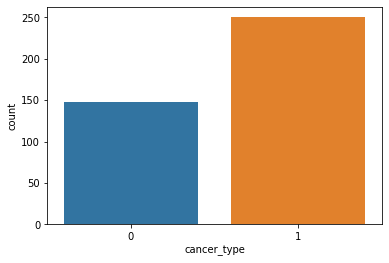

In [65]:
ax = sns.countplot(df_train[target_col], label="Count")


In [66]:
df_train[target_col].value_counts()


1    250
0    148
Name: cancer_type, dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

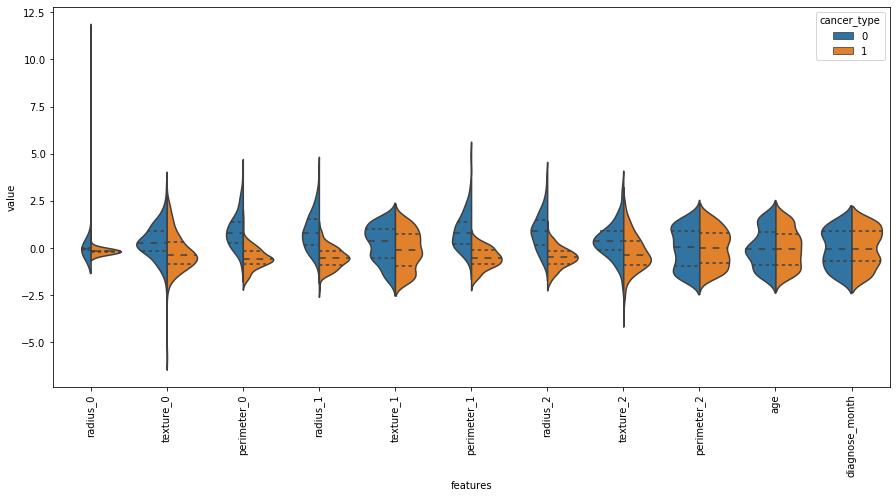

In [67]:
data_y = df_train[target_col]
data_x = df_train.drop([target_col]+dates_col, axis=1)

# standardization
data_x_stand = (data_x - data_x.mean()) / (data_x.std()) 

data_plot = pd.concat([data_y, data_x_stand], axis=1)

data_plot = pd.melt(data_plot,
                    id_vars=target_col,
                    var_name="features",
                    value_name='value',
                   )

plt.figure(figsize=(15, 7))

sns.violinplot(x="features", 
               y="value", 
               hue=target_col, 
               data=data_plot,
               split=True, 
               inner="quart",
              )

plt.xticks(rotation=90)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

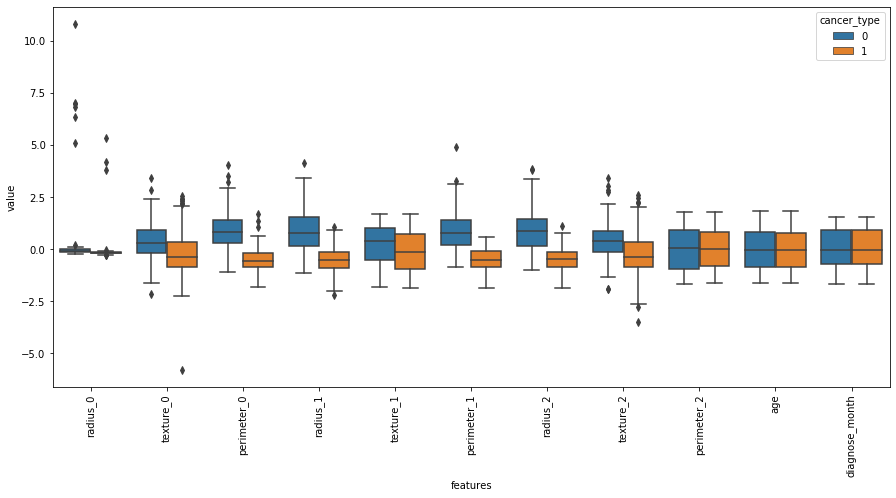

In [77]:
plt.figure(figsize=(15, 7))

sns.boxplot(x="features", 
            y="value", 
            hue=target_col, 
            data=data_plot,
           )

plt.xticks(rotation=90)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

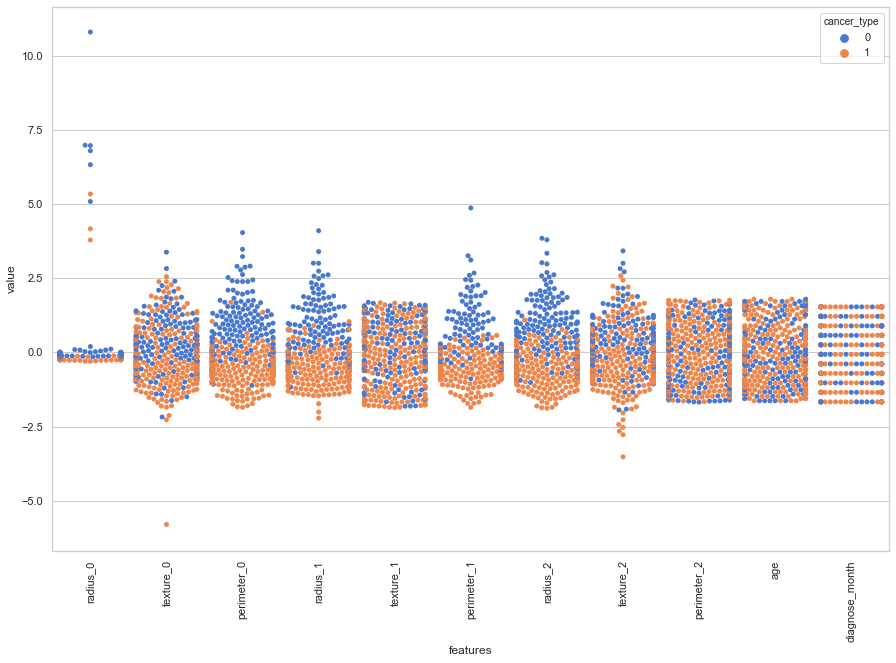

In [82]:
sns.set(style="whitegrid", palette="muted")

plt.figure(figsize=(15, 10))

#tic = time.time()
sns.swarmplot(x="features", 
              y="value", 
              hue=target_col, 
              data=data_plot,
             )


plt.xticks(rotation=90)


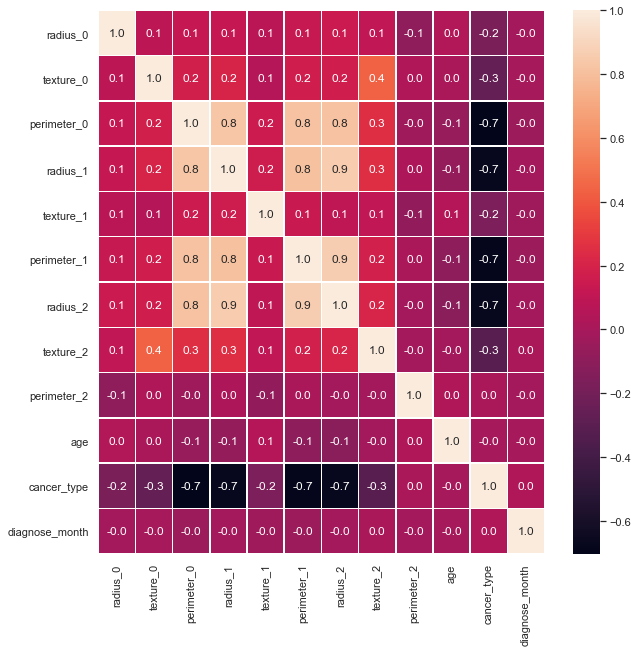

In [87]:
#correlation map
f,ax = plt.subplots(figsize=(10, 10))

sns.heatmap(df_train.drop(dates_col, axis=1).corr(), 
            annot=True, 
            linewidths=.5, 
            fmt= '.1f',
            ax=ax,
           )


## Plot number of patients per month


In [97]:
def plot_cancer_per_month(cancer_type,
                          df_train, 
                          target_col,
                          month_col='diagnose_month',
                         ):
    
    couts = df_train[df_train[target_col]==cancer_type][month_col].value_counts().sort_index(ascending=False)

    sns.set_style('white')
    fig, ax = plt.subplots(figsize=(12,5))

    ax.bar(couts.index, couts.values, color='lightblue')
    ax.plot(couts, linestyle=':', color='black')

    ax.set_title('\nNumber of patients (cancer type {}) per month\n'.format(cancer_type), 
             fontsize=14, 
             fontweight='bold',
            )
    ax.set(ylabel='\nNumber of patients (cancer type {})'.format(cancer_type))
    ax.set(xlabel='\nMonth')

    sns.despine(ax=ax, top=True, right=True, left=True, bottom=True);
    
    return
    

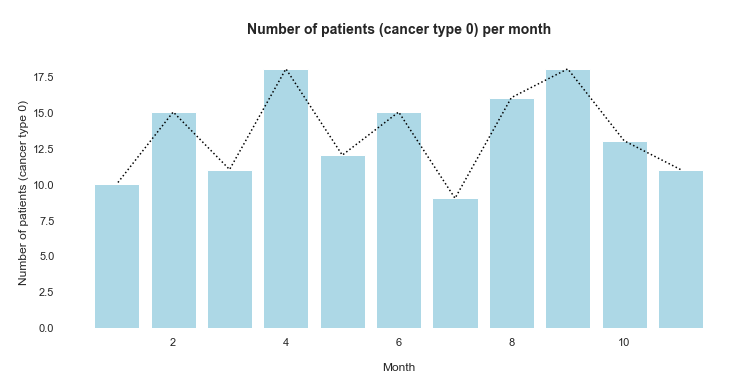

In [99]:
plot_cancer_per_month(0, df_train, target_col)


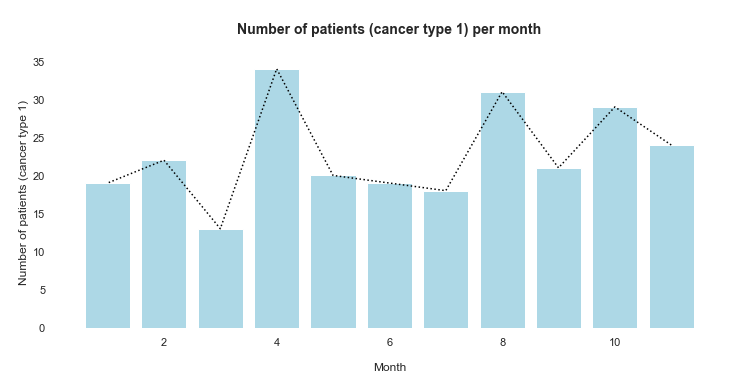

In [100]:
plot_cancer_per_month(1, df_train, target_col)


## Number of patients throughout the year


In [109]:
def plot_cancer_per_year(df_train,
                         target_col,
                         cancer_type,
                         date_col='diagnose_date',
                        ):
    
    sns.set_style('white')
    fig, ax = plt.subplots(figsize=(10,6))

    df_plot = df_train[df_train[target_col]==cancer_type]
    
    df_plot[date_col].dt.year.hist(bins=24, ax=ax, color='lightblue')
    
    ax.set_title('\nPatients (cancer type = {}) through the year\n'.format(cancer_type), 
                 fontsize=14, 
                 fontweight='bold',
                )
    ax.set(xlabel='Year', 
           ylabel='Number of patients (cancer type = {})'.format(cancer_type))

    # remove all spines
    sns.despine(top=True, right=True, left=True, bottom=True);
    return



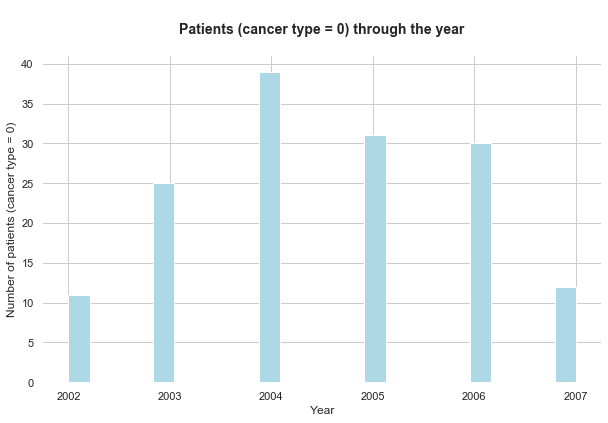

In [112]:
plot_cancer_per_year(df_train, target_col, 0)


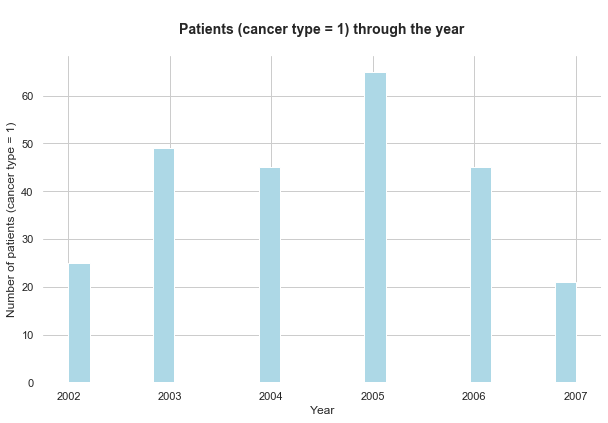

In [113]:
plot_cancer_per_year(df_train, target_col, 1)


In [114]:
df_train['diagnose_year'] = df_train['diagnose_date'].dt.year 


In [115]:
def highlight_max(data, color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    #remove % and cast to float
    data = data.replace('%','', regex=True).astype(float)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else:  # from .apply(axis=None)
        is_max = data == data.max().max()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)
    

In [120]:
df_counts = df_train.groupby(['diagnose_year', 'cancer_type']).size()

df_counts = df_counts.rename_axis(['diagnose_year', 'cancer_type']).unstack('cancer_type').reindex(columns=[0, 1])
df_counts.style.apply(highlight_max, axis=1)


cancer_type,0,1
diagnose_year,,
2002,11,25
2003,25,49
2004,39,45
2005,31,65
2006,30,45
2007,12,21


### Age


In [125]:
df_train['age'].unique()


array([44, 59, 37, 51, 21, 27, 40, 43, 50, 63, 25, 64, 18, 36, 38, 47, 54,
       62, 28, 39, 20, 60, 22, 23, 41, 34, 42, 48, 31, 26, 46, 55, 57, 35,
       56, 32, 52, 19, 49, 53, 30, 29, 61, 24, 58, 33, 45])

In [129]:
def plot_cancer_per_age(df_train,
                        target_col,
                        cancer_type,
                        age_col='age',
                        ):
    
    sns.set_style('white')
    fig, ax = plt.subplots(figsize=(10,6))

    df_plot = df_train[df_train[target_col]==cancer_type]
    
    df_plot[age_col].hist(bins=24, ax=ax, color='lightblue')
    
    ax.set_title('\nPatients (cancer type = {}) through age\n'.format(cancer_type), 
                 fontsize=14, 
                 fontweight='bold',
                )
    ax.set(xlabel='Age', 
           ylabel='Number of patients (cancer type = {})'.format(cancer_type))

    # remove all spines
    sns.despine(top=True, right=True, left=True, bottom=True);
    return


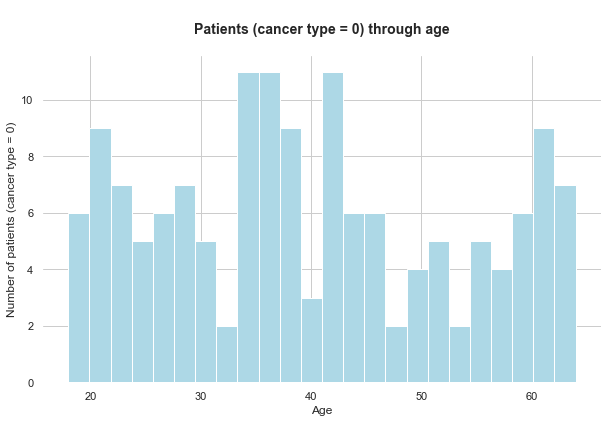

In [130]:
plot_cancer_per_age(df_train, target_col, 0)


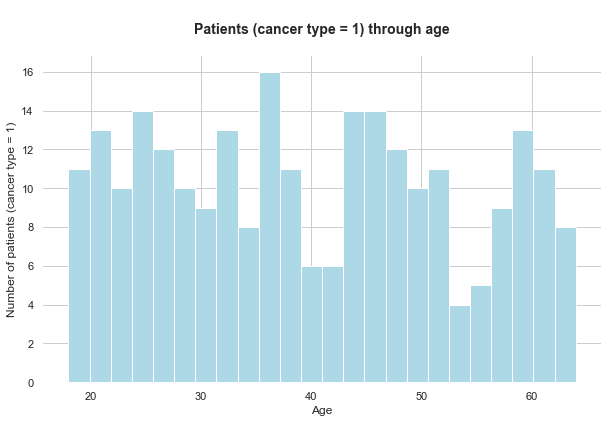

In [131]:
plot_cancer_per_age(df_train, target_col, 1)


## Feature Engineering


### Handling missing values


In [136]:
vars_with_na = [
    var for var in df_train.columns
    if df_train[var].isnull().sum() > 0 and df_train[var].dtypes != 'O'
]

# print percentage of missing values per variable
df_train[vars_with_na].isnull().mean()


radius_1       0.138191
perimeter_1    0.336683
texture_2      0.040201
dtype: float64

In [137]:
df_train['radius_1'].describe()


count    343.000000
mean      14.123575
std        3.780636
min        5.752395
25%       11.600838
50%       13.385789
75%       16.051640
max       29.645166
Name: radius_1, dtype: float64

In [138]:
df_train['perimeter_1'].describe()


count    264.000000
mean      94.086379
std       27.314466
min       43.444930
25%       75.188880
50%       90.054613
75%      106.085670
max      227.162938
Name: perimeter_1, dtype: float64

In [139]:
df_train['texture_2'].describe()


count    382.000000
mean      19.459098
std        5.802189
min       -0.966998
25%       15.456557
50%       19.436094
75%       22.944174
max       39.331864
Name: texture_2, dtype: float64

In [140]:
df_train[vars_with_na] = df_train[vars_with_na].fillna(0)
df_test[vars_with_na] = df_test[vars_with_na].fillna(0)


### Handling outliers

- triming
    - removing outliers from the dataset
- missing data
    - treat outliers as missing data and perform missing data imputation
- discretisation
    - put outliers into lower/upper bins
- cebsoring
    - capping
    - top/bottom coding
    - winsorization


#### Detect outliers
- gaussian distribution (mean and std)
- inter-quantal range proximity rule
- quantiles


In [141]:
df_train.columns

Index(['radius_0', 'texture_0', 'perimeter_0', 'radius_1', 'texture_1',
       'perimeter_1', 'radius_2', 'texture_2', 'perimeter_2', 'age',
       'treatment_date', 'diagnose_date', 'cancer_type', 'diagnose_month',
       'diagnose_year'],
      dtype='object')

In [154]:
def plot_var(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.distplot(df[variable], bins=30)
    plt.title('{} Histogram'.format(variable))

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')
    plt.title('{} q-q plot'.format(variable))

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('{} Boxplot'.format(variable));

    plt.show()
    

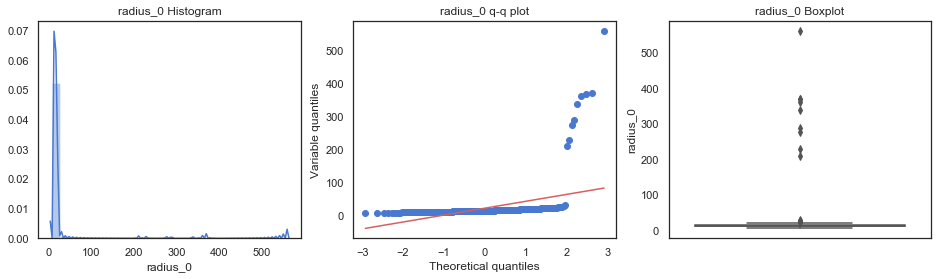

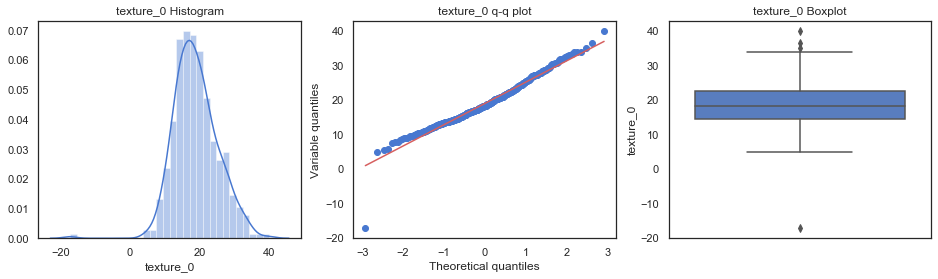

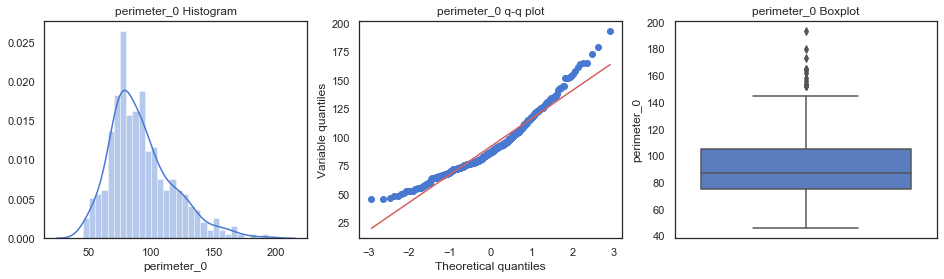

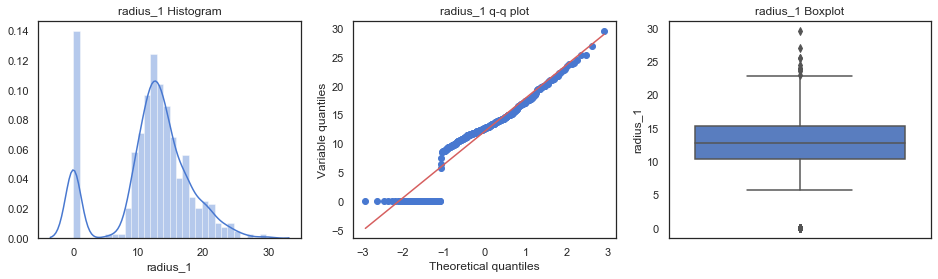

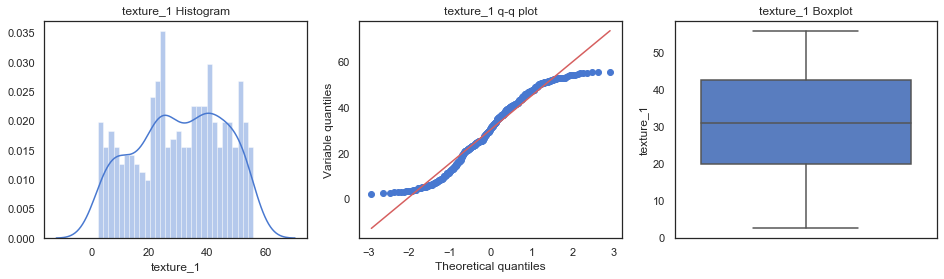

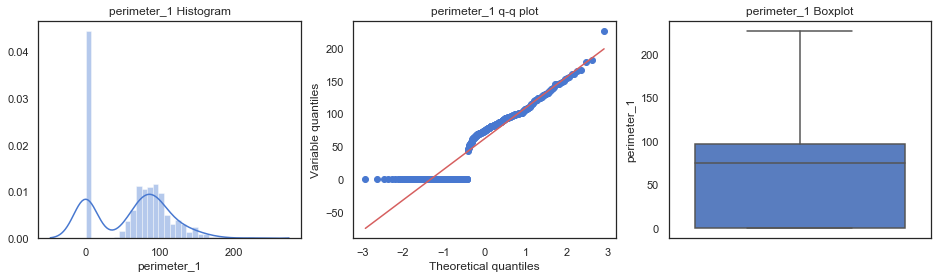

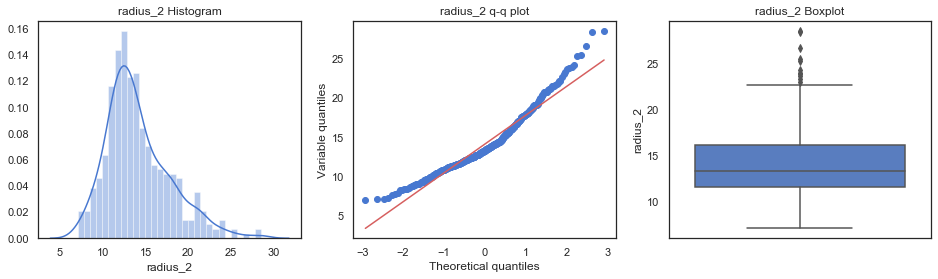

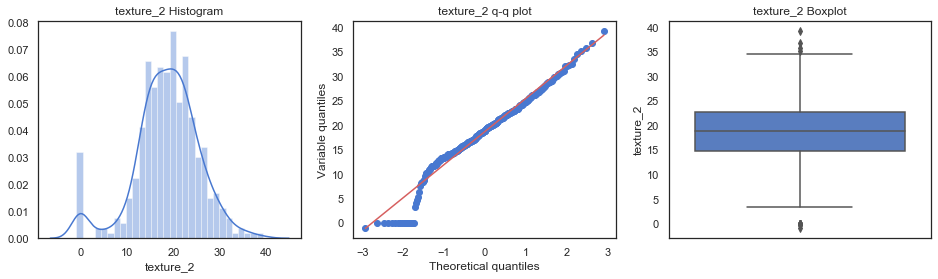

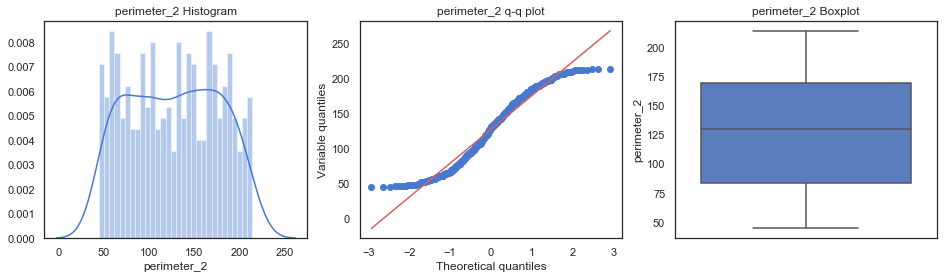

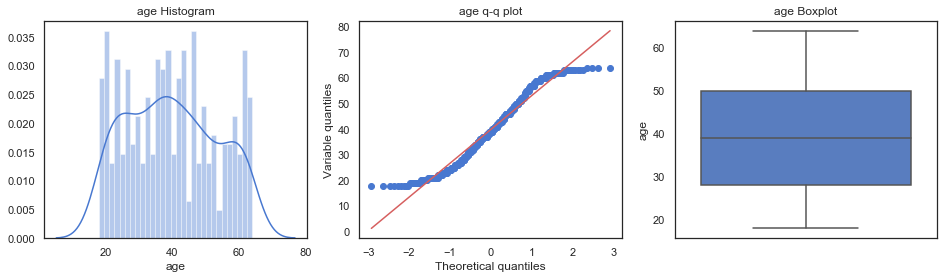

In [155]:
cols = ['radius_0', 'texture_0', 'perimeter_0', 'radius_1', 'texture_1', 
        'perimeter_1', 'radius_2', 'texture_2', 'perimeter_2', 'age']

for col in cols:
    plot_var(df_train, col) 


## Modeling


## Feature Analysis


## Saving prediction to a file
